<div align="center">

### Lab 4

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 4: Predicting Stock Price with Deep Learning

</div>

### Introduction

In this lab, we explore the application of time-series datasets using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network, to predict stock prices. Specifically, we will use historical price data from Nvidia to forecast the stock's price for the next day based on the prices of the previous N days. This approach is particularly relevant given the volatile nature of stock markets and the increasing reliance on automated trading systems.

### Objectives

- To understand the fundamentals of LSTM networks and their application in time-series forecasting.
- To develop a predictive model that can accurately forecast Nvidia's stock price for the next day using historical data.

### Dataset

The dataset for this lab is from the "Huge Stock Market Dataset" available on Kaggle. This dataset includes daily prices and volumes for all US stocks and ETFs, with a specific focus on Nvidia (NVDA). The dataset features include:

- **Date**: The recorded data points.
- **Open**: The price at which the stock first traded upon the opening of an exchange on a given trading day.
- **High**: The highest price at which the stock traded during the trading day.
- **Low**: The lowest price at which the stock traded during the trading day.
- **Close**: The price of the stock at closing time.
- **Volume**: The number of shares or contracts traded in a security or an entire market during a given period.
- **OpenInt**: The total number of outstanding derivative contracts, like options or futures. [More details here](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/discussion/121096)

### References

- [Huge Stock Market Dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) for the dataset used in this lab.


## X. Checking and Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NTHU_2025_DLIA_HW/HW4/nvda.us.txt')
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-01-22,1.6238,1.8092,1.4379,1.5215,18297633,0
1,1999-01-25,1.6423,1.6980,1.5215,1.6793,3445279,0
2,1999-01-26,1.6980,1.7350,1.5311,1.5494,2320993,0
3,1999-01-27,1.5586,1.5957,1.4660,1.5494,1662658,0
4,1999-01-28,1.5494,1.5586,1.5311,1.5401,1540110,0
...,...,...,...,...,...,...,...
4728,2017-11-06,207.2000,209.9800,206.7000,209.6300,9731783,0
4729,2017-11-07,210.5500,212.9000,210.0560,212.0000,10671815,0
4730,2017-11-08,211.8500,212.0000,207.2400,209.1600,13033902,0
4731,2017-11-09,205.2700,206.3300,200.3700,205.3200,23895006,0


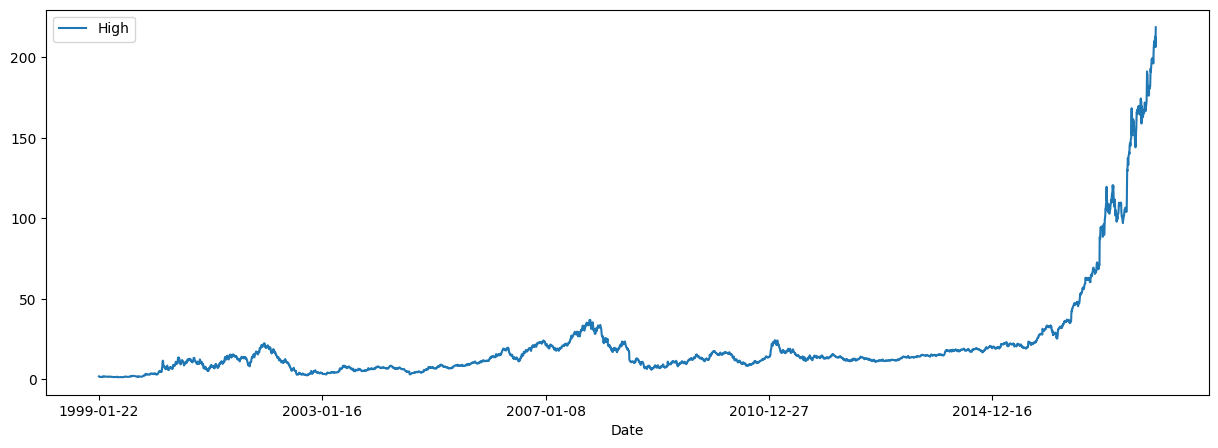

In [ ]:
plot = df.plot('Date', 'High', figsize=(15, 5))

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
import time
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4733 entries, 0 to 4732
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     4733 non-null   object 
 1   Open     4733 non-null   float64
 2   High     4733 non-null   float64
 3   Low      4733 non-null   float64
 4   Close    4733 non-null   float64
 5   Volume   4733 non-null   int64  
 6   OpenInt  4733 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 259.0+ KB


In [ ]:
# checking for null values
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0
OpenInt,0


In [ ]:
df = df.dropna()

In [ ]:
df.shape

(4733, 7)

In [ ]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,4733.000000,4733.000000,4733.000000,4733.000000,4.733000e+03,4733.0
mean,20.796242,21.157332,20.420417,20.805404,1.615287e+07,0.0
std,30.236284,30.615622,29.792958,30.263705,1.272446e+07,0.0
min,1.298900,1.317500,1.233900,1.261900,0.000000e+00,0.0
25%,7.988300,8.247900,7.756400,7.978900,8.181100e+06,0.0
50%,12.963000,13.238000,12.721000,12.990000,1.390271e+07,0.0
75%,19.141000,19.418000,18.778000,19.106000,2.051602e+07,0.0
max,213.080000,218.670000,211.630000,216.140000,2.496659e+08,0.0


### B. Defining Neural Networks

## A. Experiment with different window sizes and steps

In [ ]:
# Check your GPU status.
!nvidia-smi

Tue Apr 29 02:09:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Function to run an experiment with a given window size and step
def run_experiment(df, window_size, step, epochs=50, batch_size=32, device='cuda'):
    # Select features
    features = df[['Open', 'High', 'Low', 'Close']].values
    labels = df['High'].shift(-1).values  # Next day's high price as label

    # Drop the last row since it has NaN in labels
    features = features[:-1]
    labels = labels[:-1]

    # Create sequences
    X, y = create_sequences(features, labels, window_size, step)

    print(f'Window Size: {window_size}, Step: {step}')
    print(f'Shape of data X: {X.shape}')
    print(f'Shape of data y: {y.shape}')

    # split the hold-out tests
    ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int)  # 10% hold-out
    x_test = X[ind]
    y_test = y[ind]
    all_ind = np.arange(len(X))
    remains_ind = np.delete(all_ind, ind)

    X = X[remains_ind]
    y = y[remains_ind]

    # shuffle dataset
    ind = np.random.permutation(len(X))
    X = X[ind]
    y = y[ind]

    split_point = int(X.shape[0]*0.8)

    x_train = X[:split_point]
    y_train = y[:split_point]
    x_val = X[split_point:]
    y_val = y[split_point:]

    # Convert to PyTorch tensors
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float()

    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).float()

    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).float()

    # Create datasets
    train_dataset = TensorDataset(x_train, y_train)
    val_dataset = TensorDataset(x_val, y_val)
    test_dataset = TensorDataset(x_test, y_test)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, criterion, optimizer
    model = LSTMModel(input_dim=4, hidden_dim=500, num_layers=2, output_dim=1).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    # Training loop
    for epoch in tqdm(range(epochs)):
        # Training
        model.train()
        total_loss = 0.0

        for features, labels in train_loader:
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Learning rate update
        lr_scheduler.step()

        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(device)
                labels = labels.to(device)
                outputs = model(features).squeeze(-1)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        # Checkpoint
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f'best_model_window{window_size}_step{step}.pth')

        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}')

        # Store performance
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

    # Load best model for evaluation
    model.load_state_dict(torch.load(f'best_model_window{window_size}_step{step}.pth'))
    model.eval()

    # Evaluate on test set
    test_predictions = []
    test_actuals = []

    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            outputs = model(features).squeeze(-1)
            test_predictions.append(outputs.cpu().numpy())
            test_actuals.append(labels.numpy())

    test_predictions = np.concatenate(test_predictions)
    test_actuals = np.concatenate(test_actuals)

    # Calculate MSE
    mse = ((test_predictions - test_actuals) ** 2).mean()

    # Plot predictions vs actual
    plt.figure(figsize=(12, 6))
    plt.plot(test_predictions, label='Predictions')
    plt.plot(test_actuals, label='Actual')
    plt.title(f'Window Size: {window_size}, Step: {step}, MSE: {mse:.4f}')
    plt.legend()
    plt.savefig(f'prediction_window{window_size}_step{step}.png')
    plt.close()

    # Plot training curves
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Training Curves - Window: {window_size}, Step: {step}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'training_curve_window{window_size}_step{step}.png')
    plt.close()

    return {
        'window_size': window_size,
        'step': step,
        'mse': mse,
        'train_loss': train_losses[-1],
        'val_loss': val_losses[-1]
    }

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Define configurations to test
configs = [
    {'window_size': 5, 'step': 1},   # Small window, small step
    {'window_size': 10, 'step': 5},  # Medium window, medium step
    {'window_size': 20, 'step': 10}  # Large window, large step
]

# Run experiments and collect results
results = []
for config in configs:
    result = run_experiment(df, window_size=config['window_size'], step=config['step'], epochs=50, device=device)
    results.append(result)

# Display results in a table
print("\n\n--- RESULTS ---")
print("Configuration | Train Loss | Val Loss | Test MSE")
print("--------------|------------|----------|--------")
for result in results:
    print(f"Window: {result['window_size']}, Step: {result['step']} | {result['train_loss']:.4f} | {result['val_loss']:.4f} | {result['mse']:.4f}")


Window Size: 5, Step: 1
Shape of data X: (4727, 5, 4)
Shape of data y: (4727,)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train loss: 916.7523, Val loss: 630.4249
Epoch 11/50, Train loss: 18.3472, Val loss: 12.6234
Epoch 21/50, Train loss: 7.6203, Val loss: 5.3046
Epoch 31/50, Train loss: 2.4584, Val loss: 2.8139
Epoch 41/50, Train loss: 1.8804, Val loss: 2.4584
Window Size: 10, Step: 5
Shape of data X: (945, 10, 4)
Shape of data y: (945,)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train loss: 923.2373, Val loss: 1168.6065
Epoch 11/50, Train loss: 725.5208, Val loss: 973.1955
Epoch 21/50, Train loss: 212.4134, Val loss: 301.7699
Epoch 31/50, Train loss: 117.6442, Val loss: 169.1565
Epoch 41/50, Train loss: 94.9832, Val loss: 138.1102
Window Size: 20, Step: 10
Shape of data X: (472, 20, 4)
Shape of data y: (472,)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train loss: 1069.6056, Val loss: 750.0772
Epoch 11/50, Train loss: 853.9357, Val loss: 622.2902
Epoch 21/50, Train loss: 489.0445, Val loss: 283.9649
Epoch 31/50, Train loss: 319.2586, Val loss: 168.1804
Epoch 41/50, Train loss: 271.4498, Val loss: 136.4583


--- RESULTS ---
Configuration | Train Loss | Val Loss | Test MSE
--------------|------------|----------|--------
Window: 5, Step: 1 | 1.6517 | 2.1506 | 2.7605
Window: 10, Step: 5 | 104.3581 | 134.5102 | 157.2513
Window: 20, Step: 10 | 265.8211 | 132.0193 | 492.1293


#### Visualizing the model performance

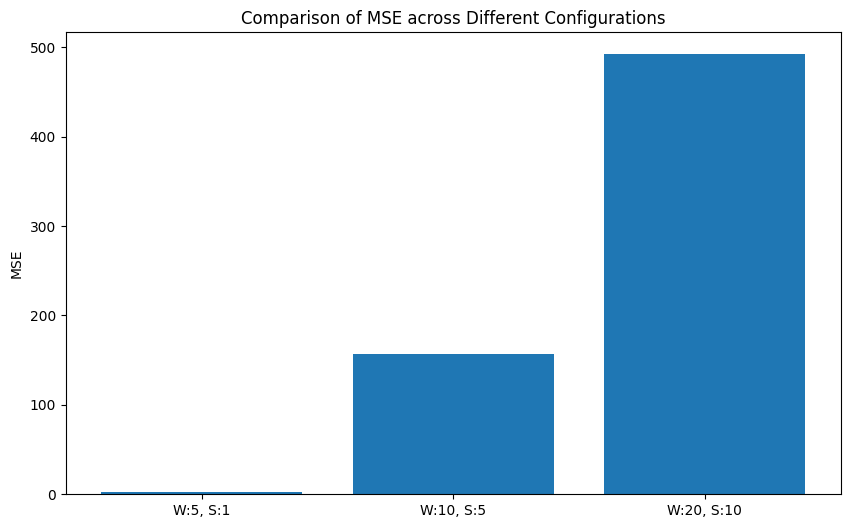

In [ ]:
# Create a comparison plot
plt.figure(figsize=(10, 6))
window_sizes = [result['window_size'] for result in results]
steps = [result['step'] for result in results]
mses = [result['mse'] for result in results]

plt.bar(range(len(results)), mses)
plt.xticks(range(len(results)), [f"W:{w}, S:{s}" for w, s in zip(window_sizes, steps)])
plt.ylabel('MSE')
plt.title('Comparison of MSE across Different Configurations')
plt.savefig('comparison_mse.png')
plt.show()

## B. Include 'Volume' and explore the best combination of input features

In [ ]:
# Load and preprocess data
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    df = df.dropna()
    return df

In [ ]:
# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Function to create sequences
def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

In [ ]:
# Prepare data for a specific window size and step with selected features
def prepare_data(df, window_size, step, feature_columns, batch_size=32):
    # Select features
    features = df[feature_columns].values
    labels = df['High'].shift(-1).values  # Next day's high price as label

    # Drop the last row since it has NaN in labels
    features = features[:-1]
    labels = labels[:-1]

    # Create sequences
    X, y = create_sequences(features, labels, window_size, step)

    print(f'Using features: {feature_columns}')
    print(f'Window Size: {window_size}, Step: {step}')
    print(f'Shape of data X: {X.shape}')
    print(f'Shape of data y: {y.shape}')

    # Split into train, val, test sets
    ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int)  # 10% hold-out
    x_test = X[ind]
    y_test = y[ind]
    all_ind = np.arange(len(X))
    remains_ind = np.delete(all_ind, ind)

    X = X[remains_ind]
    y = y[remains_ind]

    # Shuffle dataset
    ind = np.random.permutation(len(X))
    X = X[ind]
    y = y[ind]

    split_point = int(X.shape[0]*0.8)

    x_train = X[:split_point]
    y_train = y[:split_point]
    x_val = X[split_point:]
    y_val = y[split_point:]

    # Convert to PyTorch tensors
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float()

    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).float()

    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).float()

    # Create datasets
    train_dataset = TensorDataset(x_train, y_train)
    val_dataset = TensorDataset(x_val, y_val)
    test_dataset = TensorDataset(x_test, y_test)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [ ]:
# Train the model
def train_model(train_loader, val_loader, input_dim, window_size, step, epochs=50, device='cuda'):
    # Initialize model, criterion, optimizer
    model = LSTMModel(input_dim=input_dim, hidden_dim=200, num_layers=2, output_dim=1).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    # Training loop
    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0.0

        for features, labels in train_loader:
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Learning rate update
        lr_scheduler.step()

        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(device)
                labels = labels.to(device)
                outputs = model(features).squeeze(-1)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        # Checkpoint
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model_identifier = f'model_win{window_size}_step{step}_in{input_dim}'
            torch.save(model.state_dict(), f'best_{model_identifier}.pth')

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}')

        # Store performance
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

    # Load best model
    model_identifier = f'model_win{window_size}_step{step}_in{input_dim}'
    model.load_state_dict(torch.load(f'best_{model_identifier}.pth'))

    return model, train_losses, val_losses

In [ ]:
# Evaluate the model
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()

    # Evaluate on test set
    test_predictions = []
    test_actuals = []

    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            outputs = model(features).squeeze(-1)
            test_predictions.append(outputs.cpu().numpy())
            test_actuals.append(labels.numpy())

    test_predictions = np.concatenate(test_predictions)
    test_actuals = np.concatenate(test_actuals)

    # Calculate MSE
    mse = mean_squared_error(test_actuals, test_predictions)

    return test_predictions, test_actuals, mse

In [ ]:
# Run the entire experiment for one configuration
def experiment(df, window_size, step, feature_columns, epochs=30, batch_size=32, device='cuda'):
    start_time = time.time()

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(df, window_size, step, feature_columns, batch_size)

    # Get input dimension from features
    input_dim = len(feature_columns)

    # Train model
    model, train_losses, val_losses = train_model(train_loader, val_loader, input_dim, window_size, step, epochs, device)

    # Evaluate model
    predictions, actuals, mse = evaluate_model(model, test_loader, device)

    end_time = time.time()
    run_time = end_time - start_time

    # Plot predictions vs actual
    plt.figure(figsize=(12, 6))
    plt.plot(predictions[:100], label='Predictions')
    plt.plot(actuals[:100], label='Actual')
    feature_str = '_'.join([f[:3] for f in feature_columns])
    plt.title(f'Features: {feature_str}, Win: {window_size}, Step: {step}, MSE: {mse:.4f}')
    plt.legend()
    plt.savefig(f'pred_win{window_size}_step{step}_{feature_str}.png')
    plt.show()

    # Plot training curves
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Training Curves - Features: {feature_str}, Win: {window_size}, Step: {step}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'train_win{window_size}_step{step}_{feature_str}.png')
    plt.show()

    return {
        'window_size': window_size,
        'step': step,
        'features': feature_columns,
        'mse': mse,
        'train_loss': train_losses[-1],
        'val_loss': val_losses[-1],
        'run_time': run_time
    }

In [ ]:
# Part 1: Testing with and without Volume
def part1_volume_impact(df):
    print("\n=== PART 1: Impact of Including Volume ===\n")

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Define configurations
    window_size = 5
    step = 1

    # Features without volume
    features_without_volume = ['Open', 'High', 'Low', 'Close']

    # Features with volume
    features_with_volume = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Run experiment without volume
    print("\n--- Running experiment WITHOUT Volume ---")
    result_without_volume = experiment(
        df,
        window_size=window_size,
        step=step,
        feature_columns=features_without_volume,
        epochs=30,
        batch_size=32,
        device=device
    )

    # Run experiment with volume
    print("\n--- Running experiment WITH Volume ---")
    result_with_volume = experiment(
        df,
        window_size=window_size,
        step=step,
        feature_columns=features_with_volume,
        epochs=30,
        batch_size=32,
        device=device
    )

    # Display results in a table
    print("\n\n--- VOLUME IMPACT RESULTS ---")
    print("Configuration | Features | Train Loss | Val Loss | Test MSE | Run Time (s)")
    print("--------------|----------|------------|----------|----------|------------")
    print(f"Without Volume | {', '.join(features_without_volume)} | {result_without_volume['train_loss']:.4f} | {result_without_volume['val_loss']:.4f} | {result_without_volume['mse']:.4f} | {result_without_volume['run_time']:.2f}")
    print(f"With Volume | {', '.join(features_with_volume)} | {result_with_volume['train_loss']:.4f} | {result_with_volume['val_loss']:.4f} | {result_with_volume['mse']:.4f} | {result_with_volume['run_time']:.2f}")

    # Calculate improvement percentage
    improvement = ((result_without_volume['mse'] - result_with_volume['mse']) / result_without_volume['mse']) * 100

    print(f"\nIncluding Volume {'improved' if improvement > 0 else 'worsened'} the MSE by {abs(improvement):.2f}%")

    # Create a comparison bar chart
    plt.figure(figsize=(10, 6))
    configurations = ['Without Volume', 'With Volume']
    mses = [result_without_volume['mse'], result_with_volume['mse']]

    plt.bar(configurations, mses)
    plt.ylabel('MSE')
    plt.title('Impact of Including Volume on MSE')
    plt.savefig('volume_impact_comparison.png')
    plt.show()

    # Return the results for potential future use
    return result_without_volume, result_with_volume


In [ ]:
# Part 2: Finding the best feature combination
def part2_best_feature_combination(df):
    print("\n=== PART 2: Finding the Best Feature Combination ===\n")

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Define configurations
    window_size = 5
    step = 1

    # All available features
    all_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']

    # Test some meaningful combinations (not all possible combinations to save time)
    feature_combinations = [
        ['Open', 'Close'],  # Just opening and closing prices
        ['High', 'Low'],    # Just the range
        ['Open', 'High', 'Low', 'Close'],  # Standard OHLC
        ['Open', 'High', 'Low', 'Close', 'Volume'],  # OHLC + Volume
        ['Open', 'Close', 'Volume'],  # Price movement + volume
        ['High', 'Volume'],  # Just high price and volume
        ['Close', 'Volume', 'OpenInt']  # Close, volume, and open interest
    ]

    # Run experiments for each feature combination
    results = []
    for features in feature_combinations:
        print(f"\n--- Testing feature combination: {features} ---")
        result = experiment(
            df,
            window_size=window_size,
            step=step,
            feature_columns=features,
            epochs=30,
            batch_size=32,
            device=device
        )
        results.append(result)

    # Find the best combination
    best_result = min(results, key=lambda x: x['mse'])

    # Display results in a table
    print("\n\n--- FEATURE COMBINATION RESULTS ---")
    print("Features | Train Loss | Val Loss | Test MSE | Run Time (s)")
    print("---------|------------|----------|----------|------------")
    for result in results:
        feature_str = ', '.join(result['features'])
        print(f"{feature_str} | {result['train_loss']:.4f} | {result['val_loss']:.4f} | {result['mse']:.4f} | {result['run_time']:.2f}")

    print(f"\nBest Feature Combination: {', '.join(best_result['features'])}")
    print(f"Best MSE: {best_result['mse']:.4f}")

    # Create a comparison bar chart
    plt.figure(figsize=(12, 6))
    feature_labels = ['+'.join([f[:1] for f in result['features']]) for result in results]
    mses = [result['mse'] for result in results]

    # Create bar chart with annotations
    bars = plt.bar(feature_labels, mses)
    plt.ylabel('MSE')
    plt.title('MSE by Feature Combination')

    # Highlight the best combination
    best_index = mses.index(min(mses))
    bars[best_index].set_color('green')

    # Add value annotations
    for i, v in enumerate(mses):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center')

    plt.tight_layout()
    plt.savefig('feature_combination_comparison.png')
    plt.show()

    return results



=== PART 1: Impact of Including Volume ===

Using device: cuda

--- Running experiment WITHOUT Volume ---
Using features: ['Open', 'High', 'Low', 'Close']
Window Size: 5, Step: 1
Shape of data X: (4727, 5, 4)
Shape of data y: (4727,)
Epoch 1/30, Train loss: 965.6705, Val loss: 740.9372
Epoch 11/30, Train loss: 91.3925, Val loss: 81.0059
Epoch 21/30, Train loss: 25.3337, Val loss: 26.9678
Epoch 30/30, Train loss: 19.4855, Val loss: 22.3057


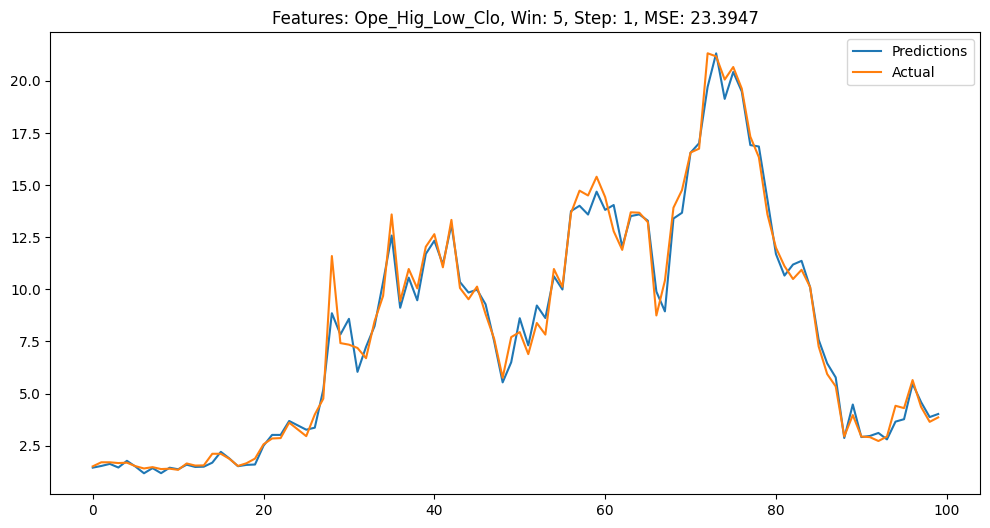

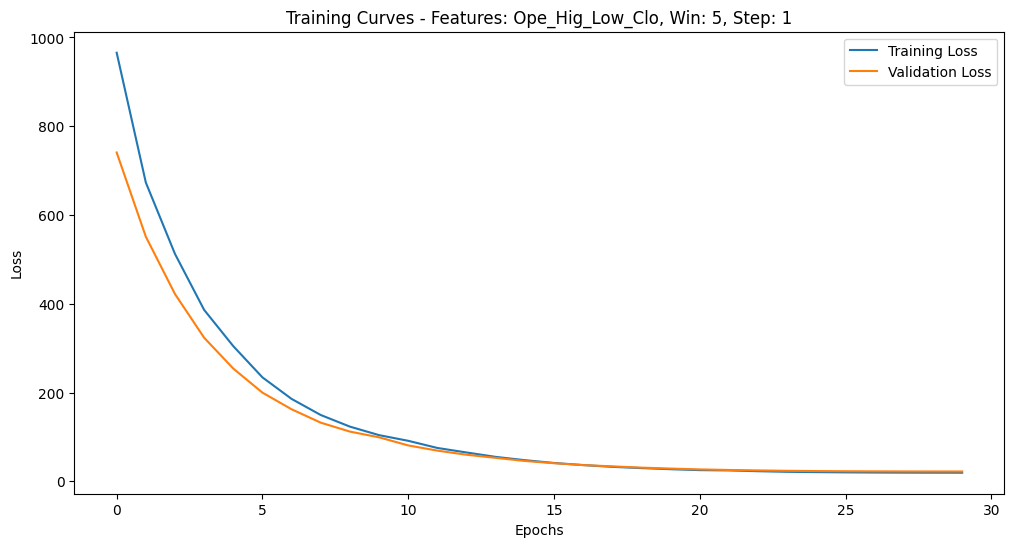


--- Running experiment WITH Volume ---
Using features: ['Open', 'High', 'Low', 'Close', 'Volume']
Window Size: 5, Step: 1
Shape of data X: (4727, 5, 5)
Shape of data y: (4727,)
Epoch 1/30, Train loss: 1036.2571, Val loss: 882.3711
Epoch 11/30, Train loss: 948.3777, Val loss: 880.3416
Epoch 21/30, Train loss: 943.7293, Val loss: 880.3262
Epoch 30/30, Train loss: 943.4546, Val loss: 880.3029


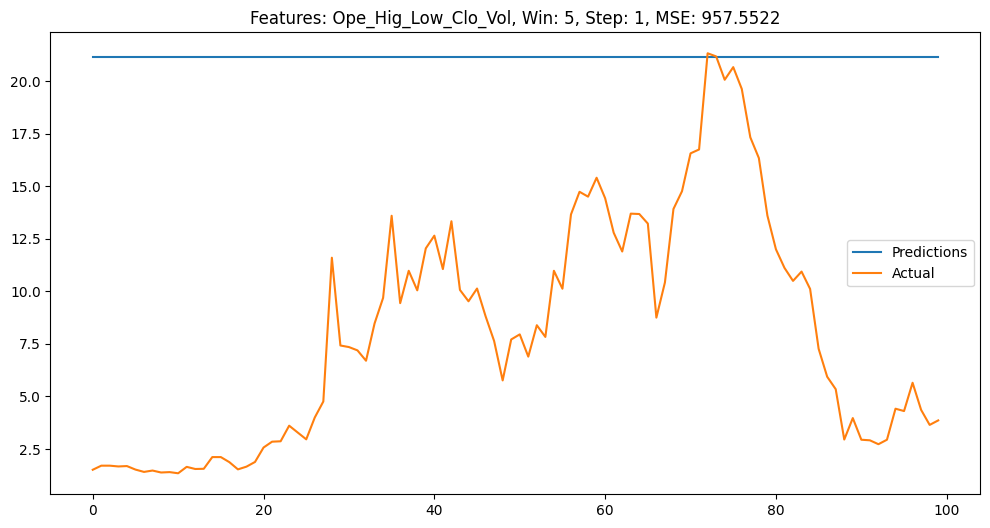

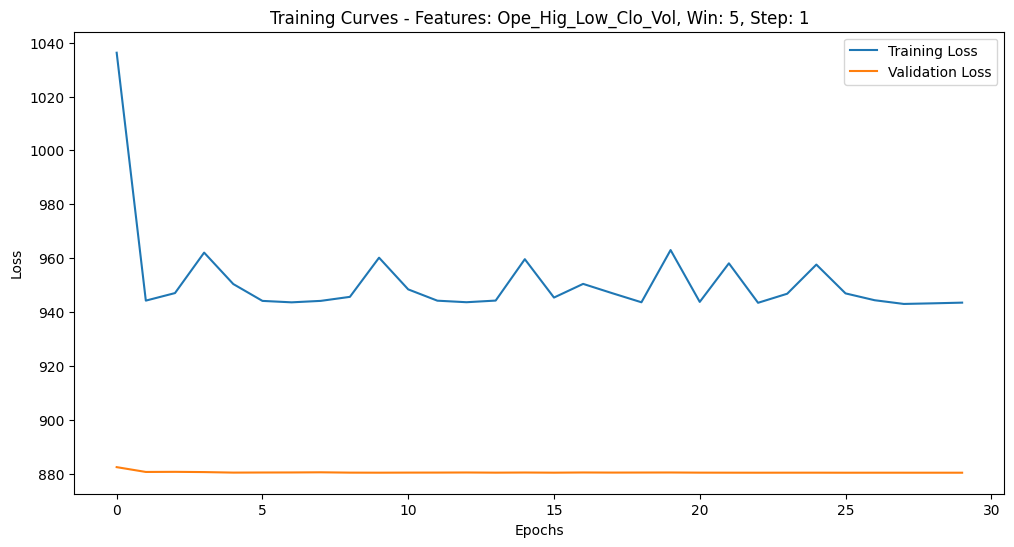



--- VOLUME IMPACT RESULTS ---
Configuration | Features | Train Loss | Val Loss | Test MSE | Run Time (s)
--------------|----------|------------|----------|----------|------------
Without Volume | Open, High, Low, Close | 19.4855 | 22.3057 | 23.3947 | 19.29
With Volume | Open, High, Low, Close, Volume | 943.4546 | 880.3029 | 957.5522 | 11.71

Including Volume worsened the MSE by 3993.03%


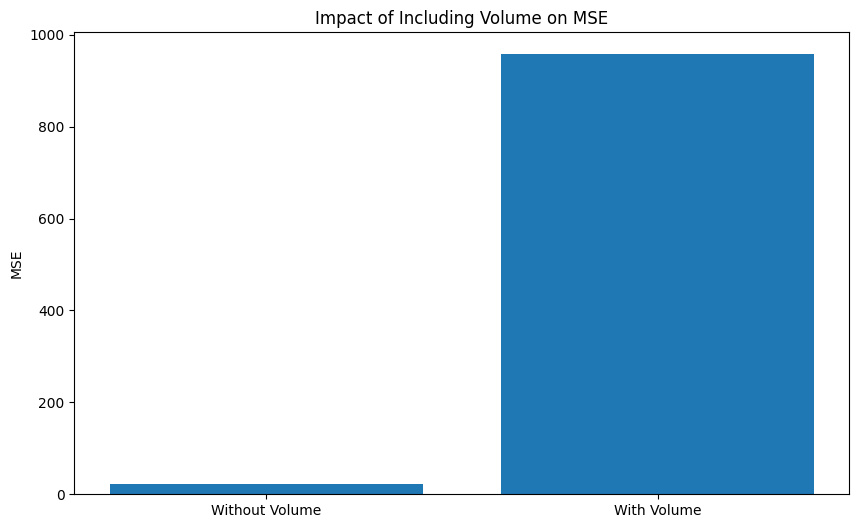


=== PART 2: Finding the Best Feature Combination ===

Using device: cuda

--- Testing feature combination: ['Open', 'Close'] ---
Using features: ['Open', 'Close']
Window Size: 5, Step: 1
Shape of data X: (4727, 5, 2)
Shape of data y: (4727,)
Epoch 1/30, Train loss: 960.6230, Val loss: 846.6893
Epoch 11/30, Train loss: 95.9980, Val loss: 104.6956
Epoch 21/30, Train loss: 28.8612, Val loss: 33.8500
Epoch 30/30, Train loss: 22.2579, Val loss: 27.2465


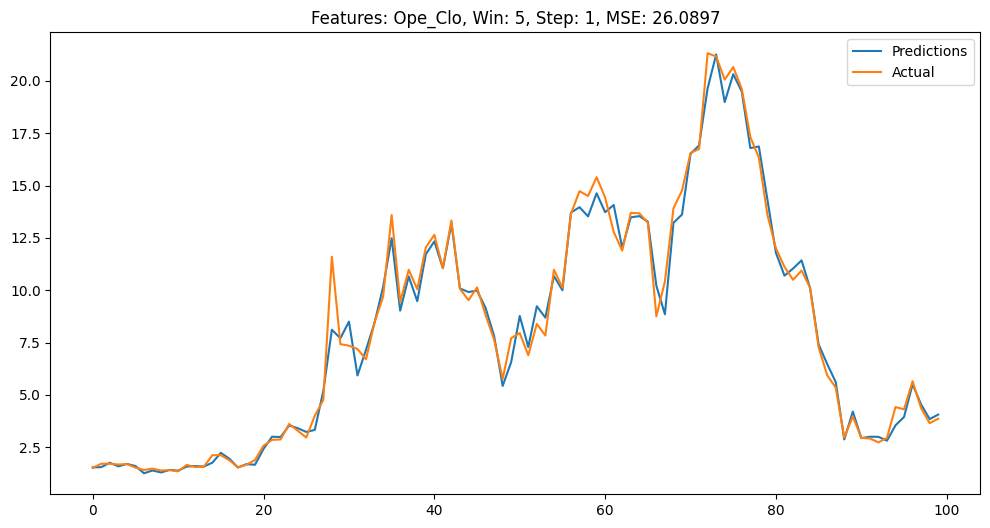

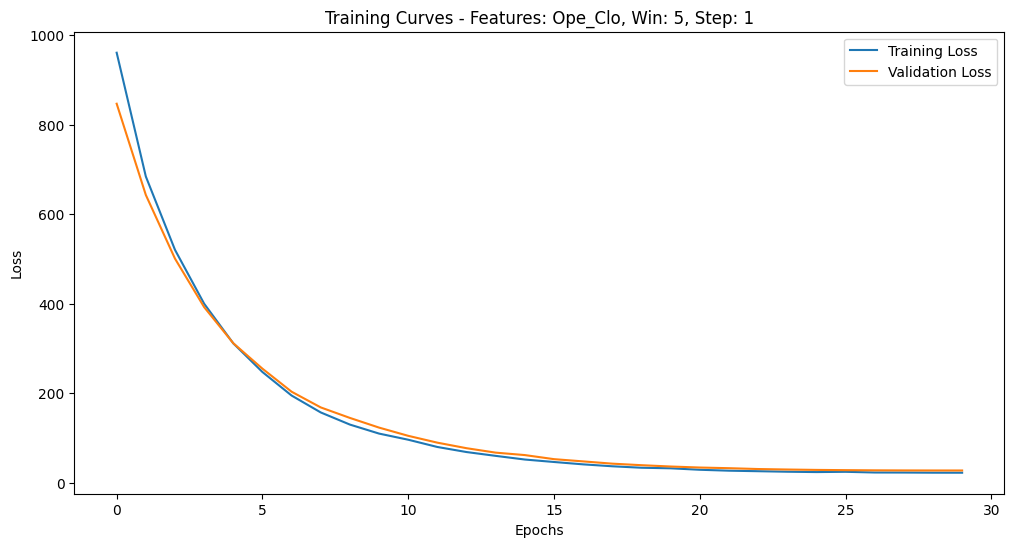


--- Testing feature combination: ['High', 'Low'] ---
Using features: ['High', 'Low']
Window Size: 5, Step: 1
Shape of data X: (4727, 5, 2)
Shape of data y: (4727,)
Epoch 1/30, Train loss: 971.0172, Val loss: 814.6897
Epoch 11/30, Train loss: 96.3644, Val loss: 77.9459
Epoch 21/30, Train loss: 27.7331, Val loss: 21.5609
Epoch 30/30, Train loss: 21.5820, Val loss: 17.0010


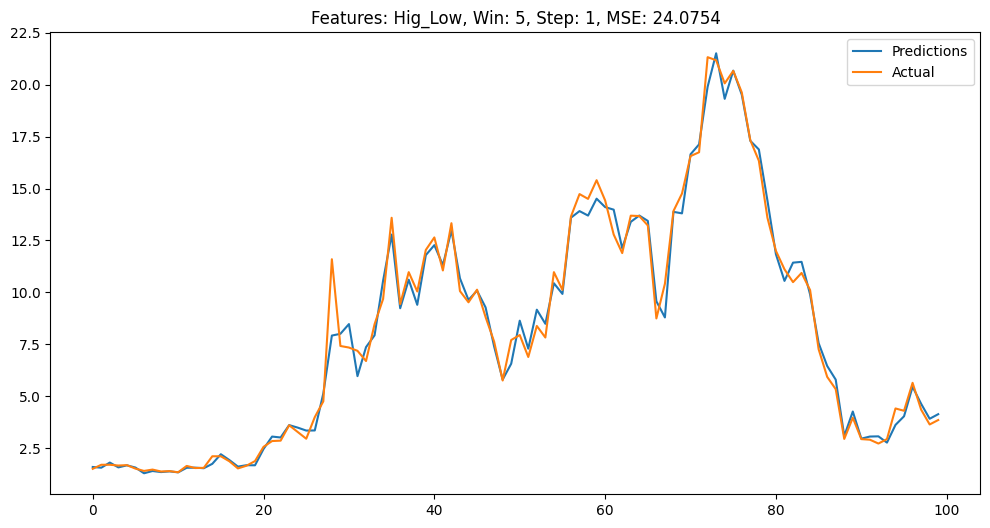

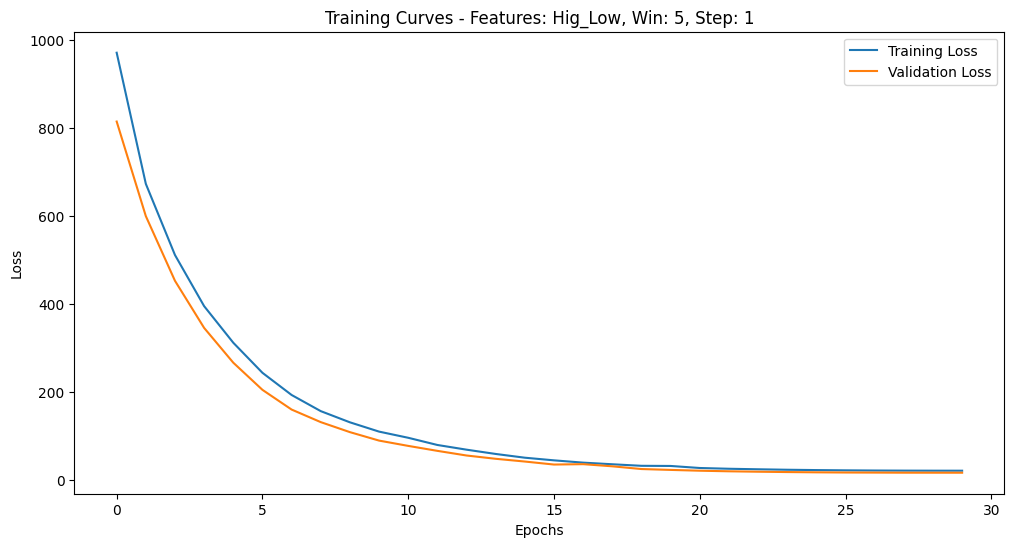


--- Testing feature combination: ['Open', 'High', 'Low', 'Close'] ---
Using features: ['Open', 'High', 'Low', 'Close']
Window Size: 5, Step: 1
Shape of data X: (4727, 5, 4)
Shape of data y: (4727,)
Epoch 1/30, Train loss: 1027.8836, Val loss: 689.1186
Epoch 11/30, Train loss: 103.5838, Val loss: 68.9211
Epoch 21/30, Train loss: 32.0006, Val loss: 16.0103
Epoch 30/30, Train loss: 24.9397, Val loss: 11.6703


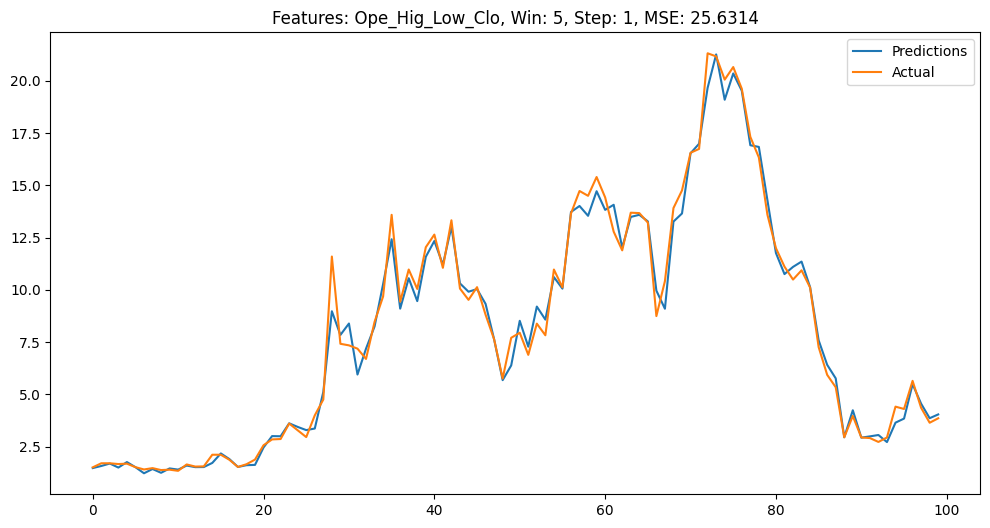

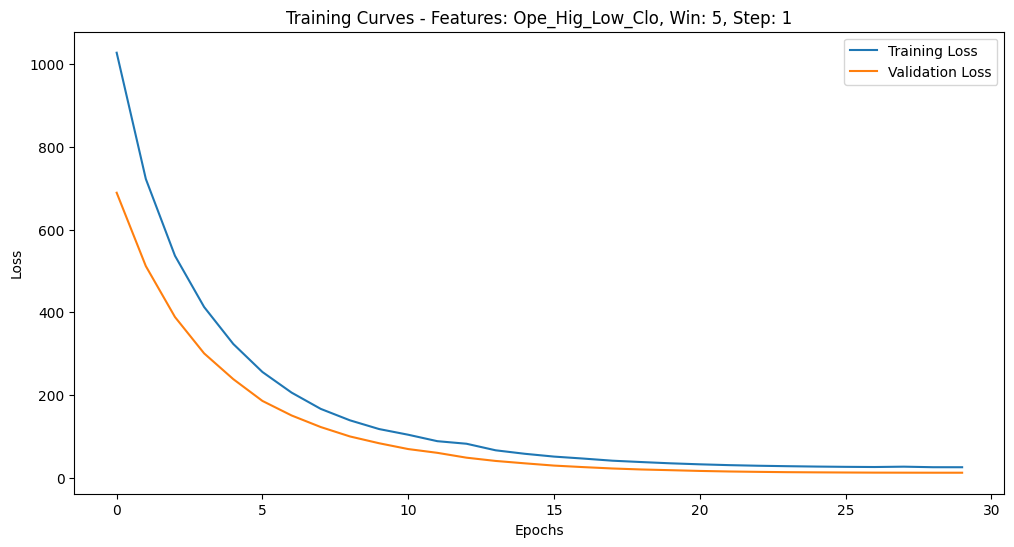


--- Testing feature combination: ['Open', 'High', 'Low', 'Close', 'Volume'] ---
Using features: ['Open', 'High', 'Low', 'Close', 'Volume']
Window Size: 5, Step: 1
Shape of data X: (4727, 5, 5)
Shape of data y: (4727,)
Epoch 1/30, Train loss: 988.9707, Val loss: 1058.0724
Epoch 11/30, Train loss: 903.8302, Val loss: 1056.8864
Epoch 21/30, Train loss: 897.1440, Val loss: 1057.3150
Epoch 30/30, Train loss: 900.3758, Val loss: 1057.3024


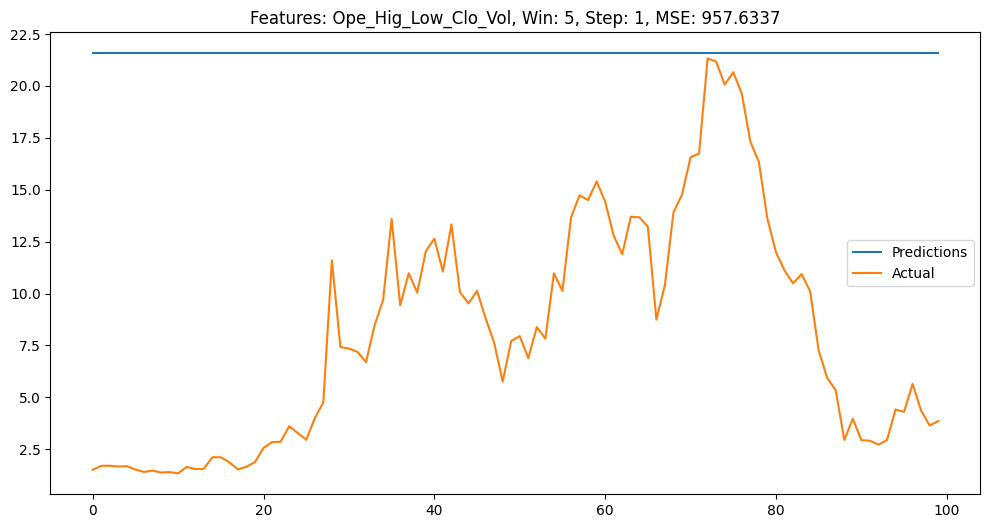

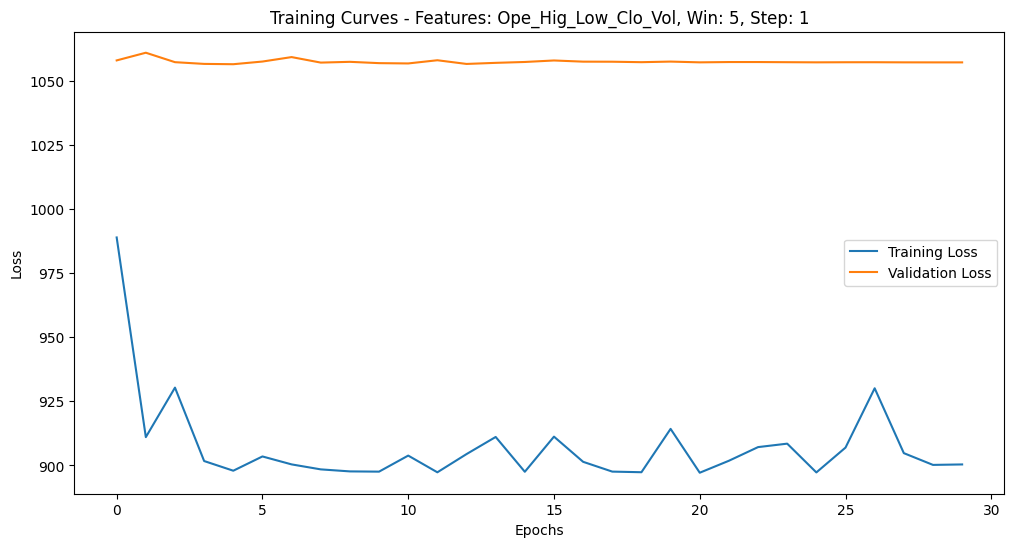


--- Testing feature combination: ['Open', 'Close', 'Volume'] ---
Using features: ['Open', 'Close', 'Volume']
Window Size: 5, Step: 1
Shape of data X: (4727, 5, 3)
Shape of data y: (4727,)
Epoch 1/30, Train loss: 1029.3412, Val loss: 919.1020
Epoch 11/30, Train loss: 939.2822, Val loss: 917.4222
Epoch 21/30, Train loss: 938.8647, Val loss: 917.4415
Epoch 30/30, Train loss: 938.6877, Val loss: 917.4312


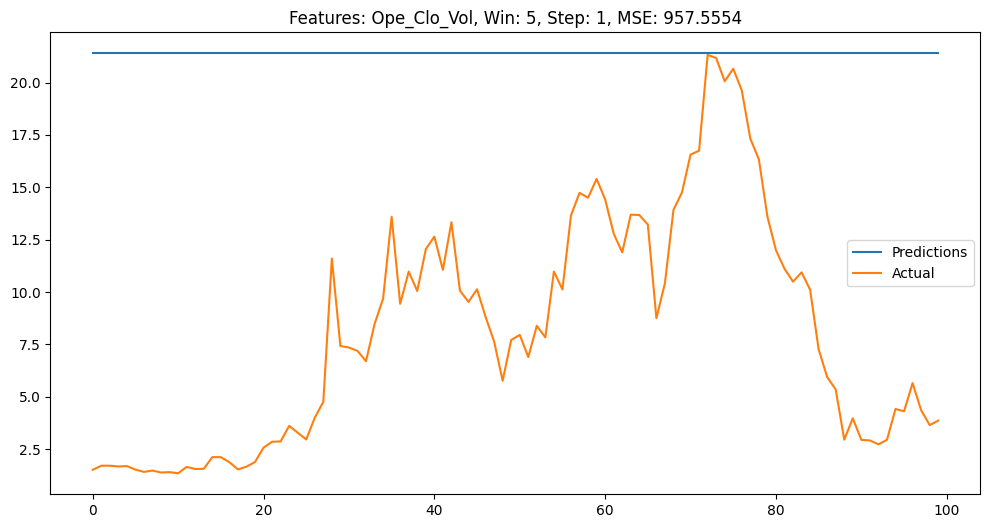

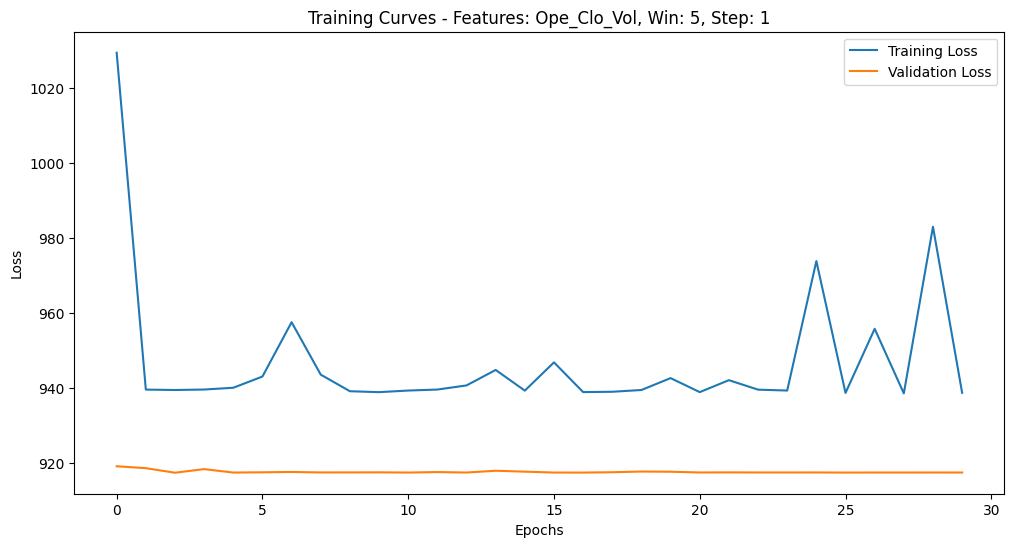


--- Testing feature combination: ['High', 'Volume'] ---
Using features: ['High', 'Volume']
Window Size: 5, Step: 1
Shape of data X: (4727, 5, 2)
Shape of data y: (4727,)
Epoch 1/30, Train loss: 1041.6067, Val loss: 931.3690
Epoch 11/30, Train loss: 945.0351, Val loss: 928.1494
Epoch 21/30, Train loss: 930.3998, Val loss: 928.2970
Epoch 30/30, Train loss: 929.4512, Val loss: 928.1915


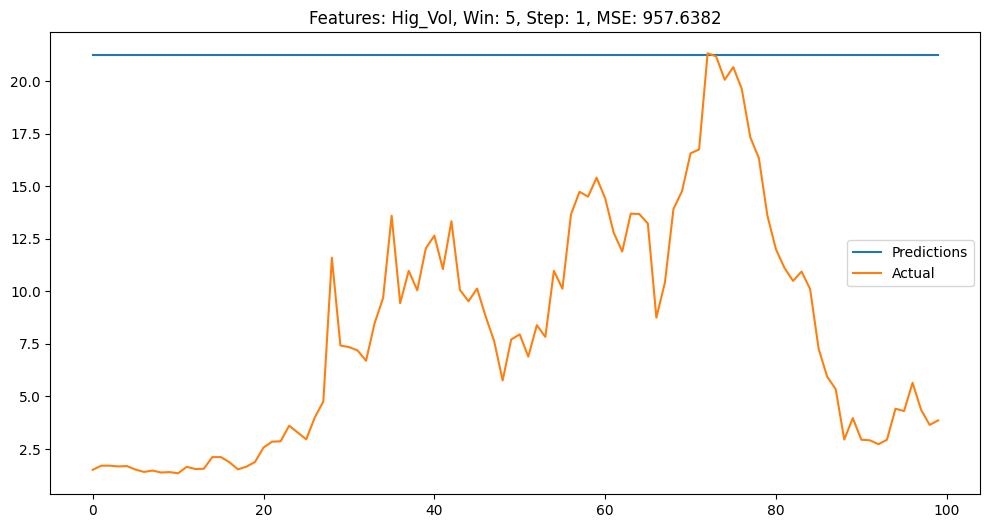

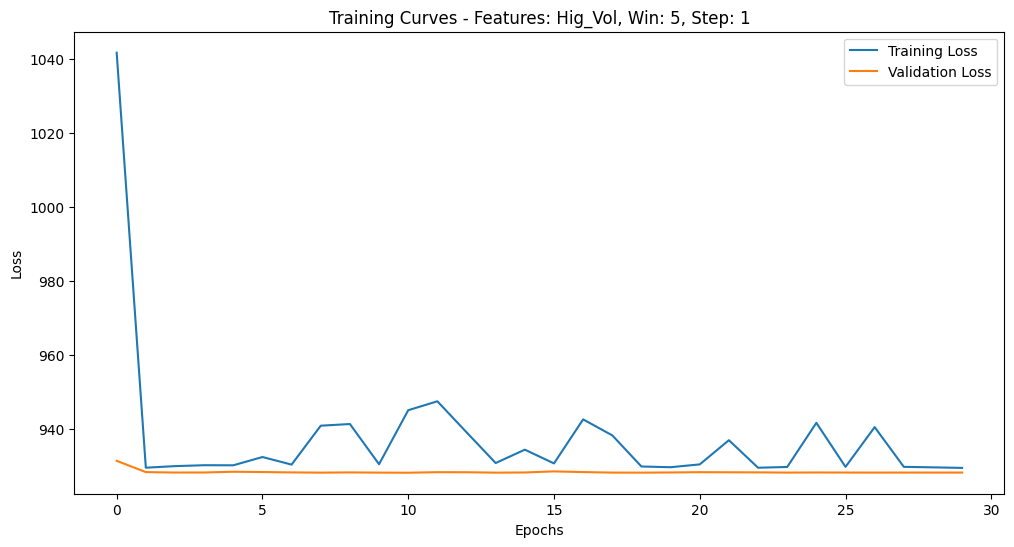


--- Testing feature combination: ['Close', 'Volume', 'OpenInt'] ---
Using features: ['Close', 'Volume', 'OpenInt']
Window Size: 5, Step: 1
Shape of data X: (4727, 5, 3)
Shape of data y: (4727,)
Epoch 1/30, Train loss: 1003.3051, Val loss: 945.7554
Epoch 11/30, Train loss: 950.0121, Val loss: 944.5087
Epoch 21/30, Train loss: 941.3534, Val loss: 944.5304
Epoch 30/30, Train loss: 925.8700, Val loss: 944.4177


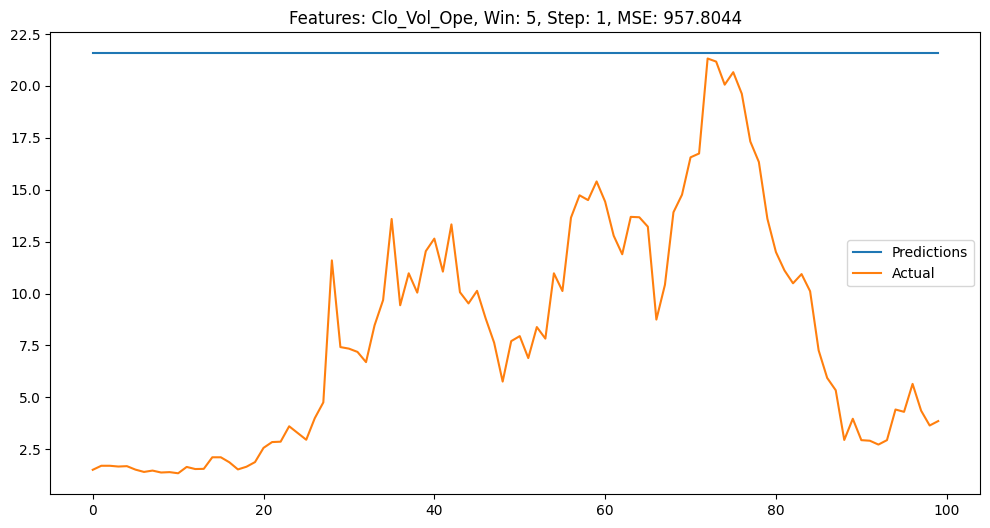

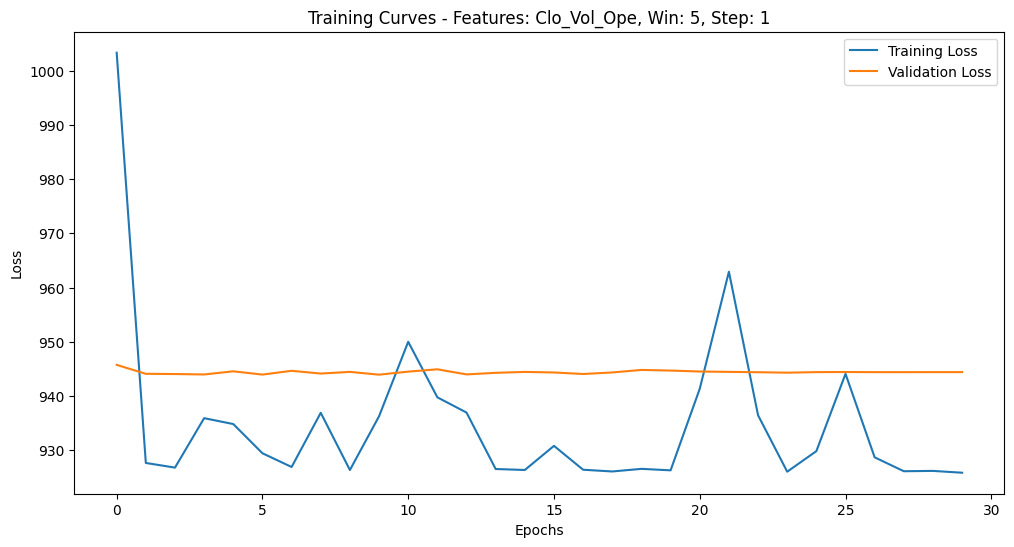



--- FEATURE COMBINATION RESULTS ---
Features | Train Loss | Val Loss | Test MSE | Run Time (s)
---------|------------|----------|----------|------------
Open, Close | 22.2579 | 27.2465 | 26.0897 | 13.30
High, Low | 21.5820 | 17.0010 | 24.0754 | 13.63
Open, High, Low, Close | 24.9397 | 11.6703 | 25.6314 | 11.52
Open, High, Low, Close, Volume | 900.3758 | 1057.3024 | 957.6337 | 11.70
Open, Close, Volume | 938.6877 | 917.4312 | 957.5554 | 11.38
High, Volume | 929.4512 | 928.1915 | 957.6382 | 11.14
Close, Volume, OpenInt | 925.8700 | 944.4177 | 957.8044 | 11.35

Best Feature Combination: High, Low
Best MSE: 24.0754


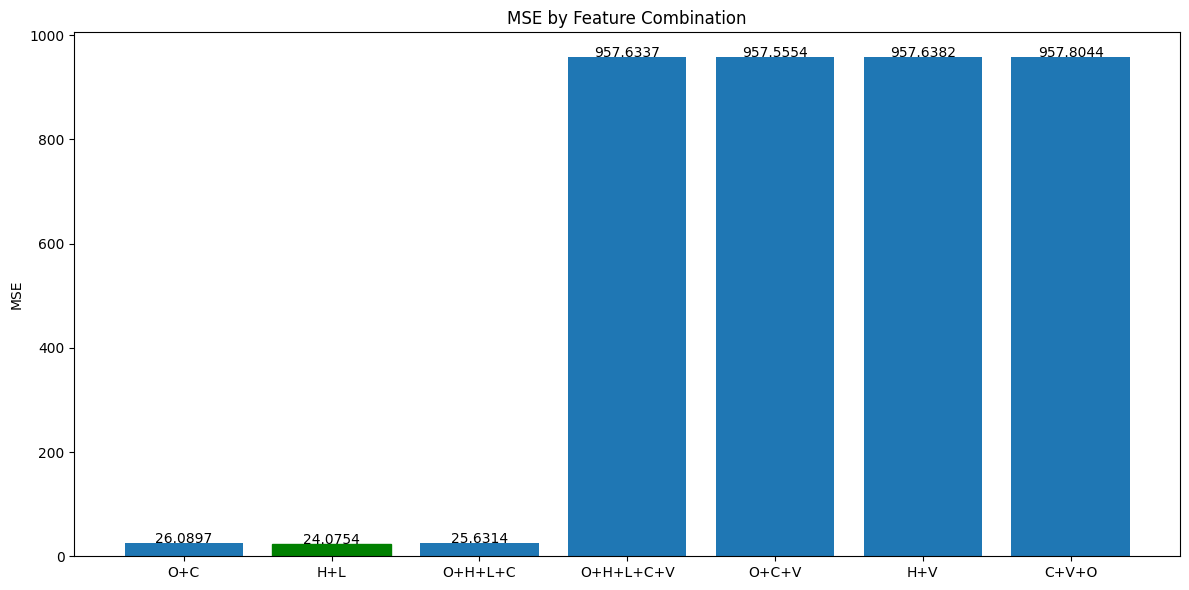

In [ ]:
# Main execution
def main():
    # Set random seed for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)

    # Load the dataset
    df = load_and_preprocess_data('/content/drive/MyDrive/Colab Notebooks/NTHU_2025_DLIA_HW/HW4/nvda.us.txt')

    # Part 1: Test the impact of including Volume
    part1_results = part1_volume_impact(df)

    # Part 2: Find the best feature combination
    part2_results = part2_best_feature_combination(df)

# Run the main function
if __name__ == "__main__":
    main()

## C. The performance of the model with and without normalized inputs

In [ ]:
# Define the LSTM Model (same as original lab)
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Function to create sequences
def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

In [ ]:
# Function to normalize data with different techniques
def normalize_data(data, method='minmax', fit_scaler=None):
    """
    Normalize data using different techniques

    Parameters:
    - data: The data to normalize
    - method: Normalization method ('none', 'minmax', 'standard', 'robust')
    - fit_scaler: Optional pre-fitted scaler for test data

    Returns:
    - normalized_data: The normalized data
    - scaler: The fitted scaler (for later inverse transformation)
    """
    if method == 'none' or method is None:
        return data, None

    if fit_scaler is not None:
        # Use provided scaler for test data
        normalized_data = fit_scaler.transform(data)
        return normalized_data, fit_scaler

    # Create a new scaler for training data
    if method == 'minmax':
        scaler = MinMaxScaler(feature_range=(0, 1))
    elif method == 'standard':
        scaler = StandardScaler()
    elif method == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError(f"Unknown normalization method: {method}")

    normalized_data = scaler.fit_transform(data)
    return normalized_data, scaler

In [ ]:
# Prepare data with normalization options
def prepare_data(df, window_size, step, feature_columns, normalization_method='none', batch_size=32):
    # Select features
    features = df[feature_columns].values
    labels = df['High'].shift(-1).values  # Next day's high price as label

    # Drop the last row since it has NaN in labels
    features = features[:-1]
    labels = labels[:-1]

    # Reshape labels for normalization (1D -> 2D)
    labels_2d = labels.reshape(-1, 1)

    # Normalize features
    normalized_features, feature_scaler = normalize_data(features, method=normalization_method)

    # Normalize labels (using same method for consistency)
    normalized_labels_2d, label_scaler = normalize_data(labels_2d, method=normalization_method)
    normalized_labels = normalized_labels_2d.flatten()

    # Create sequences
    X, y = create_sequences(normalized_features, normalized_labels, window_size, step)

    print(f'Using features: {feature_columns}')
    print(f'Normalization method: {normalization_method}')
    print(f'Window Size: {window_size}, Step: {step}')
    print(f'Shape of data X: {X.shape}')
    print(f'Shape of data y: {y.shape}')

    # Split into train, val, test sets
    ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int)  # 10% hold-out
    x_test = X[ind]
    y_test = y[ind]
    all_ind = np.arange(len(X))
    remains_ind = np.delete(all_ind, ind)

    X = X[remains_ind]
    y = y[remains_ind]

    # Shuffle dataset
    ind = np.random.permutation(len(X))
    X = X[ind]
    y = y[ind]

    split_point = int(X.shape[0]*0.8)

    x_train = X[:split_point]
    y_train = y[:split_point]
    x_val = X[split_point:]
    y_val = y[split_point:]

    # Convert to PyTorch tensors
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float()

    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).float()

    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).float()

    # Create datasets
    train_dataset = TensorDataset(x_train, y_train)
    val_dataset = TensorDataset(x_val, y_val)
    test_dataset = TensorDataset(x_test, y_test)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, feature_scaler, label_scaler

In [ ]:
# Train and evaluate model
def train_and_evaluate(df, window_size, step, feature_columns, normalization_method='none',
                      epochs=50, batch_size=32, device='cuda'):
    start_time = time.time()

    # Prepare data with specified normalization
    train_loader, val_loader, test_loader, feature_scaler, label_scaler = prepare_data(
        df, window_size, step, feature_columns, normalization_method, batch_size
    )

    # Get input dimension from features
    input_dim = len(feature_columns)

    # Initialize model, criterion, optimizer
    model = LSTMModel(input_dim=input_dim, hidden_dim=200, num_layers=2, output_dim=1).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    # Training loop
    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0.0

        for features, labels in train_loader:
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Learning rate update
        lr_scheduler.step()

        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(device)
                labels = labels.to(device)
                outputs = model(features).squeeze(-1)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        # Checkpoint
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model_identifier = f'model_win{window_size}_step{step}_norm{normalization_method}'
            torch.save(model.state_dict(), f'best_{model_identifier}.pth')

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}')

        # Store performance
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

    # Load best model for evaluation
    model_identifier = f'model_win{window_size}_step{step}_norm{normalization_method}'
    model.load_state_dict(torch.load(f'best_{model_identifier}.pth'))
    model.eval()

    # Evaluate on test set
    test_predictions = []
    test_actuals = []

    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            outputs = model(features).squeeze(-1)
            test_predictions.append(outputs.cpu().numpy())
            test_actuals.append(labels.numpy())

    test_predictions = np.concatenate(test_predictions)
    test_actuals = np.concatenate(test_actuals)

    # If normalized, convert predictions and actuals back to original scale for proper evaluation
    if label_scaler is not None:
        test_predictions = label_scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
        test_actuals = label_scaler.inverse_transform(test_actuals.reshape(-1, 1)).flatten()

    # Calculate metrics
    mse = mean_squared_error(test_actuals, test_predictions)
    rmse = np.sqrt(mse)

    end_time = time.time()
    run_time = end_time - start_time

    # Plot predictions vs actual
    plt.figure(figsize=(12, 6))
    plt.plot(test_predictions[:100], label='Predictions')
    plt.plot(test_actuals[:100], label='Actual')
    plt.title(f'Normalization: {normalization_method}, MSE: {mse:.4f}, RMSE: {rmse:.4f}')
    plt.legend()
    plt.savefig(f'pred_norm_{normalization_method}.png')
    plt.show()

    # Plot training curves
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Training Curves - Normalization: {normalization_method}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'train_norm_{normalization_method}.png')
    plt.show()

    return {
        'normalization': normalization_method,
        'mse': mse,
        'rmse': rmse,
        'train_loss': train_losses[-1],
        'val_loss': val_losses[-1],
        'run_time': run_time,
        'train_losses': train_losses,
        'val_losses': val_losses
    }

In [ ]:
# Run normalization experiment
def run_normalization_experiment(df, window_size=10, step=5, feature_columns=None, epochs=30):
    if feature_columns is None:
        feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Define normalization methods to test
    normalization_methods = ['none', 'minmax', 'standard', 'robust']

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Run experiments for each normalization method
    results = []
    for method in normalization_methods:
        print(f"\n\n{'='*50}")
        print(f"Testing normalization method: {method}")
        print(f"{'='*50}")

        result = train_and_evaluate(
            df=df,
            window_size=window_size,
            step=step,
            feature_columns=feature_columns,
            normalization_method=method,
            epochs=epochs,
            device=device
        )
        results.append(result)

    # Display results in a table
    print("\n\n--- NORMALIZATION EXPERIMENT RESULTS ---")
    print("Method | Train Loss | Val Loss | Test MSE | Test RMSE | Run Time (s)")
    print("-------|------------|----------|----------|-----------|------------")
    for result in results:
        print(f"{result['normalization']} | {result['train_loss']:.4f} | {result['val_loss']:.4f} | {result['mse']:.4f} | {result['rmse']:.4f} | {result['run_time']:.2f}")

    # Create a comparison bar chart for MSE
    plt.figure(figsize=(12, 6))
    methods = [result['normalization'] for result in results]
    mses = [result['mse'] for result in results]

    # Create bar chart with annotations
    bars = plt.bar(methods, mses)
    plt.ylabel('MSE')
    plt.title('Impact of Normalization Methods on MSE')

    # Highlight the best method
    best_index = mses.index(min(mses))
    bars[best_index].set_color('green')

    # Add value annotations
    for i, v in enumerate(mses):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center')

    plt.savefig('normalization_comparison_mse.png')
    plt.show()

    # Create a line plot comparing training curves
    plt.figure(figsize=(14, 7))
    for result in results:
        plt.plot(result['train_losses'], label=f"{result['normalization']} - Train")

    plt.title('Training Loss Comparison Across Normalization Methods')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('normalization_training_curves.png')
    plt.show()

    # Create a line plot comparing validation curves
    plt.figure(figsize=(14, 7))
    for result in results:
        plt.plot(result['val_losses'], label=f"{result['normalization']} - Val")

    plt.title('Validation Loss Comparison Across Normalization Methods')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('normalization_validation_curves.png')
    plt.show()

    return results


In [ ]:
# Load and run the experiment (to be executed in the notebook)
def main():
    # Set random seed for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)

    # Load the dataset (assuming it's available)
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NTHU_2025_DLIA_HW/HW4/nvda.us.txt')  # Update path as needed

    # Run the experiment
    results = run_normalization_experiment(
        df=df,
        window_size=5,
        step=1,
        feature_columns=['Open', 'High', 'Low', 'Close', 'Volume'],
        epochs=30
    )

    # Find the best normalization method
    best_result = min(results, key=lambda x: x['mse'])
    print(f"\nBest Normalization Method: {best_result['normalization']}")
    print(f"MSE: {best_result['mse']:.4f}")
    print(f"RMSE: {best_result['rmse']:.4f}")


Using device: cuda


Testing normalization method: none
Using features: ['Open', 'High', 'Low', 'Close', 'Volume']
Normalization method: none
Window Size: 5, Step: 1
Shape of data X: (4727, 5, 5)
Shape of data y: (4727,)
Epoch 1/30, Train loss: 1030.9599, Val loss: 898.3094
Epoch 11/30, Train loss: 941.7150, Val loss: 898.0280
Epoch 21/30, Train loss: 939.2101, Val loss: 897.9278
Epoch 30/30, Train loss: 938.4832, Val loss: 897.6890


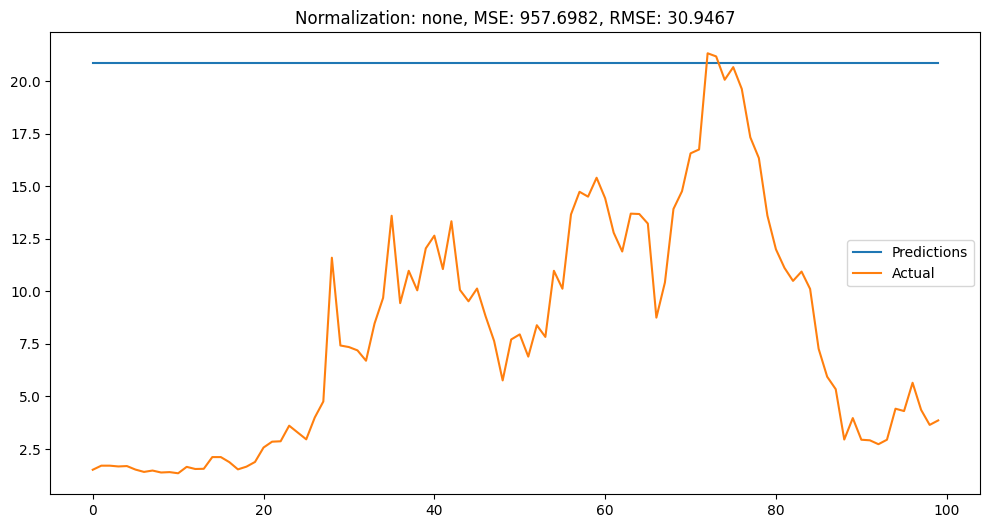

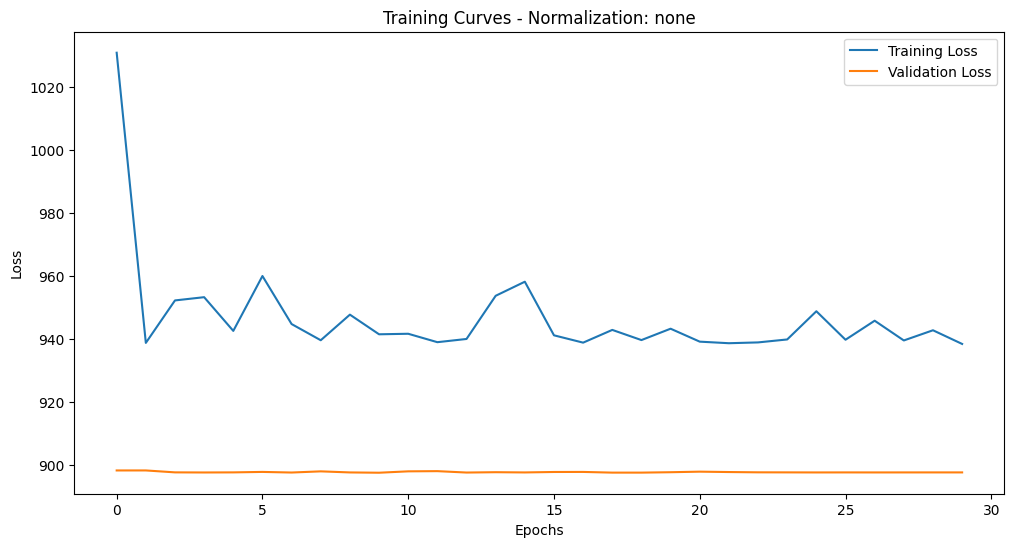



Testing normalization method: minmax
Using features: ['Open', 'High', 'Low', 'Close', 'Volume']
Normalization method: minmax
Window Size: 5, Step: 1
Shape of data X: (4727, 5, 5)
Shape of data y: (4727,)
Epoch 1/30, Train loss: 0.0032, Val loss: 0.0001
Epoch 11/30, Train loss: 0.0001, Val loss: 0.0001
Epoch 21/30, Train loss: 0.0001, Val loss: 0.0001
Epoch 30/30, Train loss: 0.0001, Val loss: 0.0000


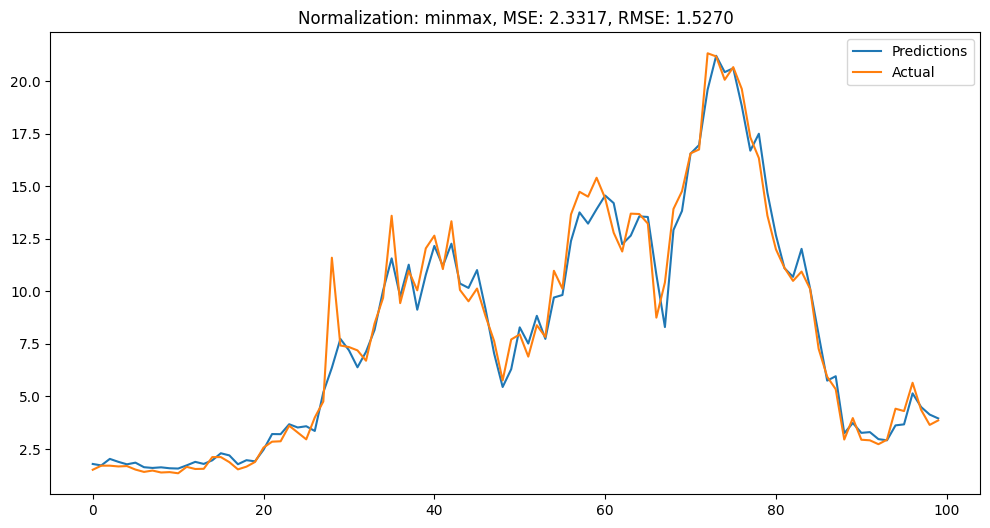

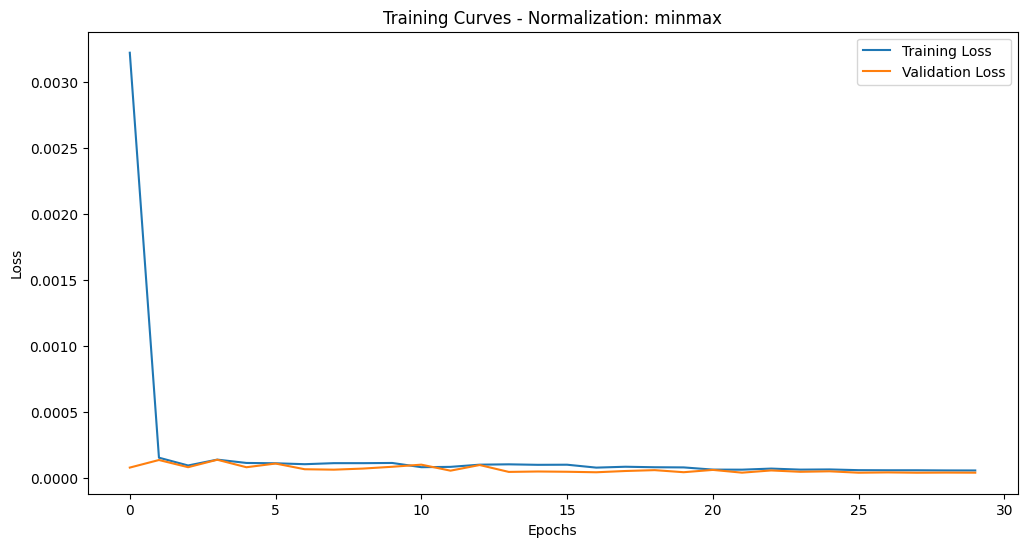



Testing normalization method: standard
Using features: ['Open', 'High', 'Low', 'Close', 'Volume']
Normalization method: standard
Window Size: 5, Step: 1
Shape of data X: (4727, 5, 5)
Shape of data y: (4727,)
Epoch 1/30, Train loss: 0.0929, Val loss: 0.0180
Epoch 11/30, Train loss: 0.0039, Val loss: 0.0039
Epoch 21/30, Train loss: 0.0020, Val loss: 0.0027
Epoch 30/30, Train loss: 0.0018, Val loss: 0.0027


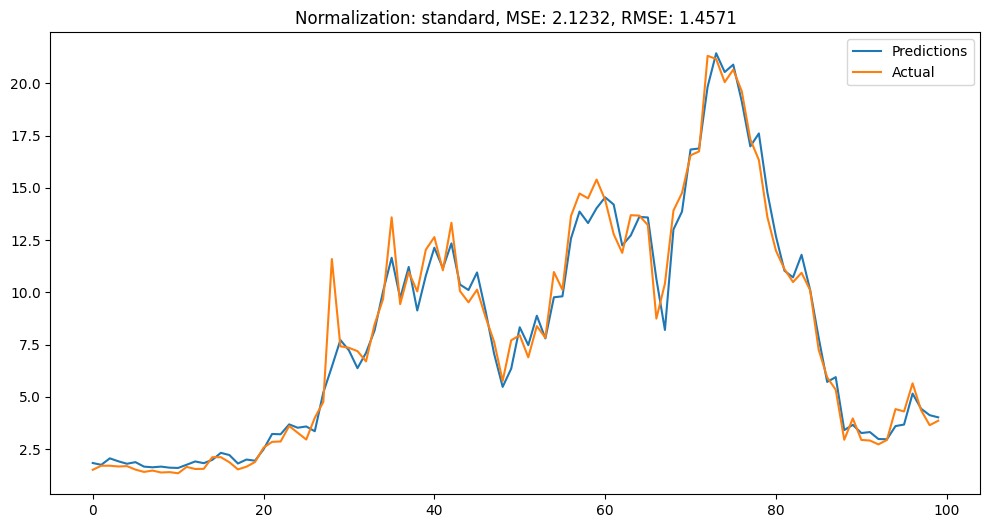

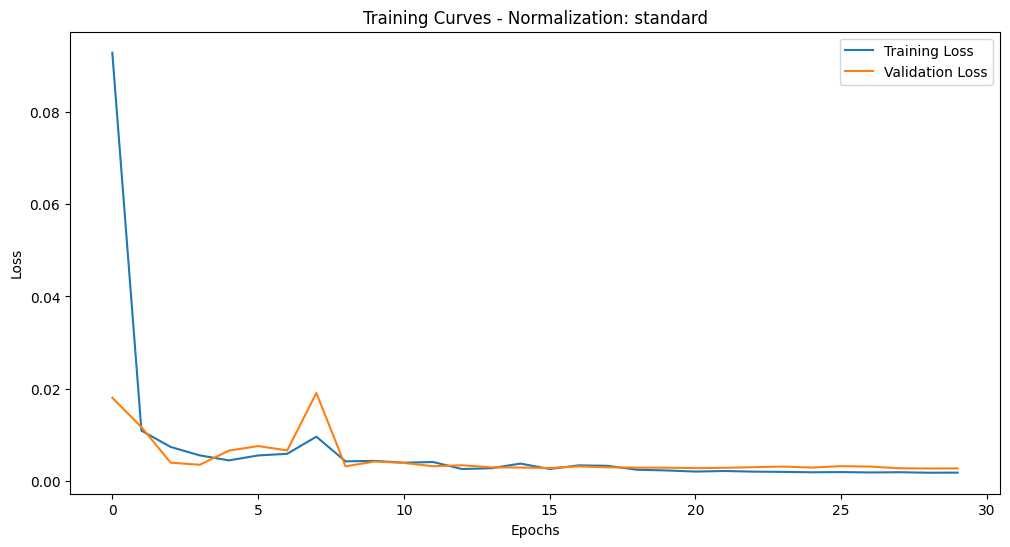



Testing normalization method: robust
Using features: ['Open', 'High', 'Low', 'Close', 'Volume']
Normalization method: robust
Window Size: 5, Step: 1
Shape of data X: (4727, 5, 5)
Shape of data y: (4727,)
Epoch 1/30, Train loss: 1.3750, Val loss: 0.1126
Epoch 11/30, Train loss: 0.0276, Val loss: 0.0263
Epoch 21/30, Train loss: 0.0162, Val loss: 0.0150
Epoch 30/30, Train loss: 0.0122, Val loss: 0.0150


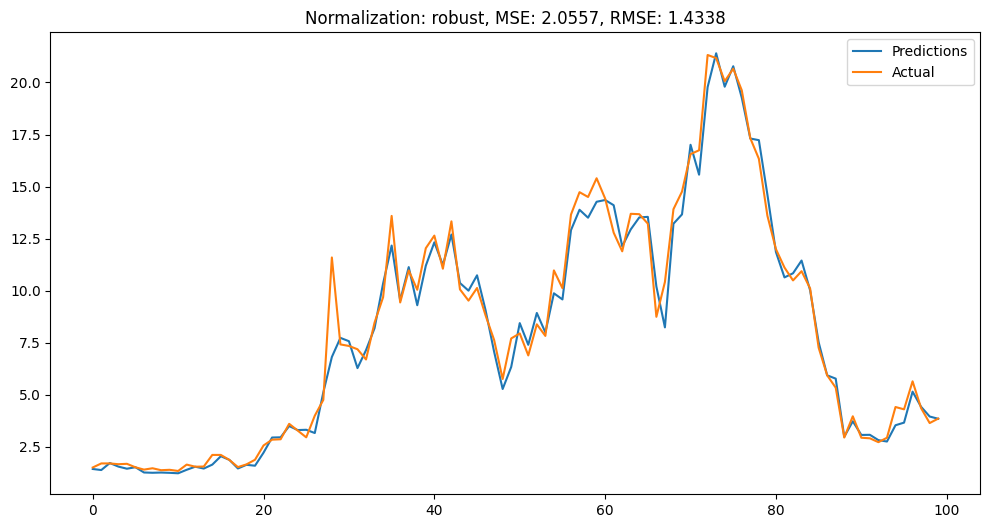

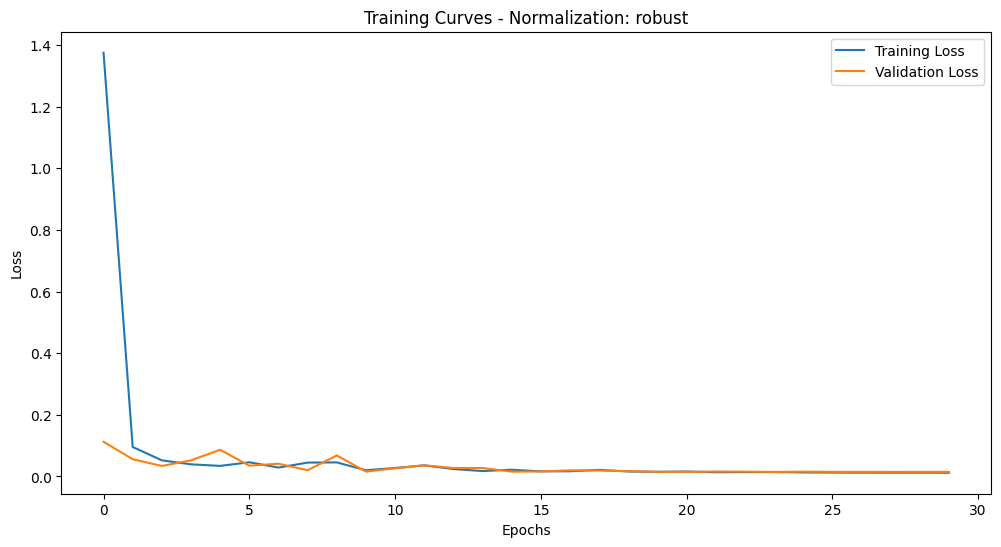



--- NORMALIZATION EXPERIMENT RESULTS ---
Method | Train Loss | Val Loss | Test MSE | Test RMSE | Run Time (s)
-------|------------|----------|----------|-----------|------------
none | 938.4832 | 897.6890 | 957.6982 | 30.9467 | 11.54
minmax | 0.0001 | 0.0000 | 2.3317 | 1.5270 | 11.42
standard | 0.0018 | 0.0027 | 2.1232 | 1.4571 | 12.41
robust | 0.0122 | 0.0150 | 2.0557 | 1.4338 | 11.36


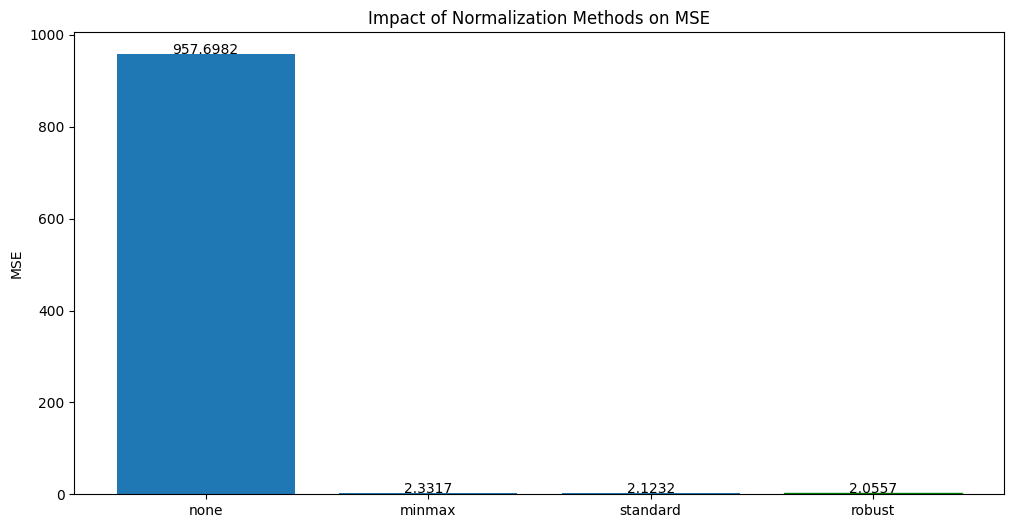

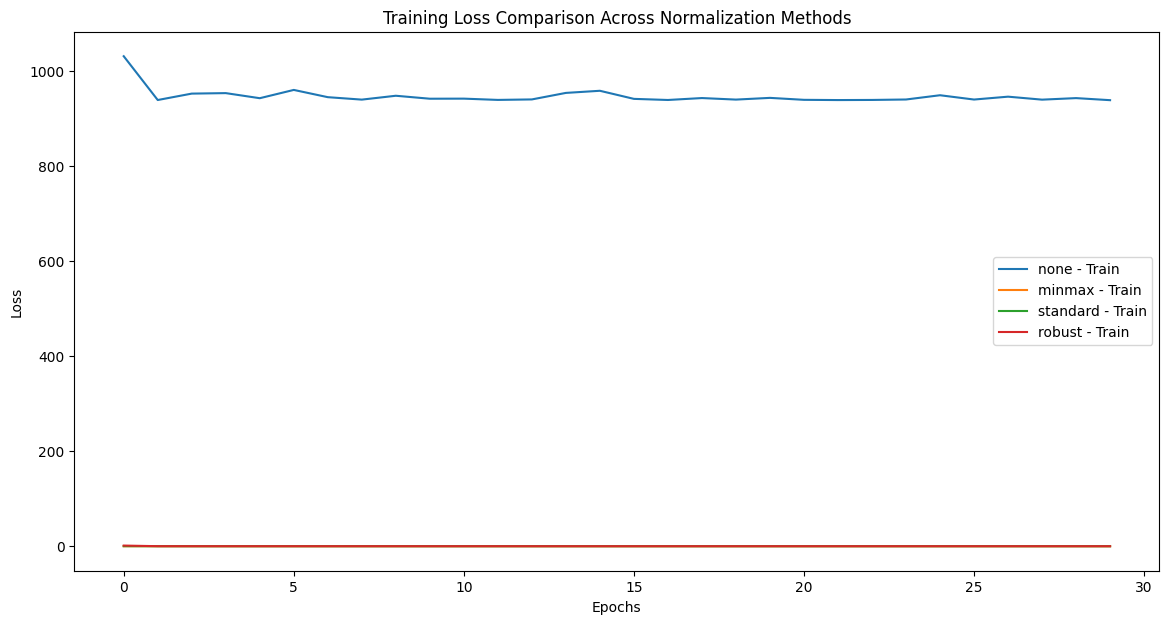

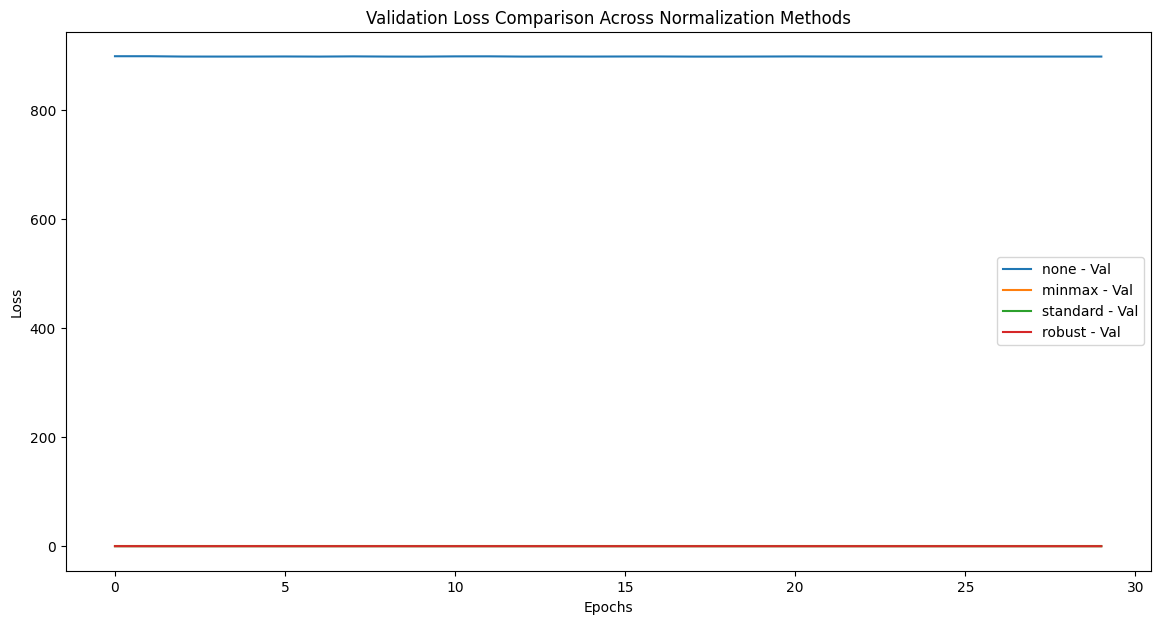


Best Normalization Method: robust
MSE: 2.0557
RMSE: 1.4338


In [ ]:
if __name__ == "__main__":
    main()